## Mathematical Description of the Model

This notebook implements a numerical method for solving **optimal control problems** involving the evolution of probability distributions governed by a controlled nonlocal continuity equation. Specifically, we study dynamics on the periodic two-dimensional domain (torus) \(\mathbb{T}^2 \equiv [0,2\pi]^2\).

The evolution of a probability density \(\rho_t(x)\) on \(\mathbb{T}^2\) is described by a controlled continuity equation of the form:

$$
\partial_t \rho_t(x) + \nabla \cdot \left(f_t[\rho_t,u_t](x)\,\rho_t(x)\right)=0,\quad \rho_0(x)=\rho_0.
$$

Here:

- \(\rho_t(x)\) is the probability density at time \(t\).
- \(u_t\) is the control input influencing the vector field.
- The drift vector field \(f_t(x,\rho,u)\) is given by a nonlocal (attention-like) mechanism:
\[
f_t(x,\rho,u) = V_t \frac{\int_{\mathbb{T}^2} k_\kappa(x,y)\,y\,\rho_t(y)\,dy}{\int_{\mathbb{T}^2} k_t(x,y)\,\rho(y)\,dy} + b_t,
\]
with the kernel
\[
k_t(x,y) = \exp\left(\kappa\, \sum_{j=1}^2 \cos(x_j - y_j)\right),
\]
which models periodic (torus-like) self-attention interactions between points. Here, the matrix \(V_t\) and bias \(b_t\) serve as learnable control parameters, and \(\kappa\) controls the concentration strength of interactions.

### Control Objective

We aim to steer the probability density \(\rho_t\) toward a desired target distribution \(\hat{\rho}(x)\) at final time \(T\). To do this, we minimize a quadratic cost functional of the form:
\[
J(u) = \int_{\mathbb{T}^2} |\rho_T(x; u) - \hat{\rho}(x)|^2\, dx.
\]

### Numerical Method

The numerical implementation relies on:

- **Spectral Methods:**  
  Fast Fourier transforms (FFT) are used to efficiently compute spatial derivatives, enhancing accuracy and computational performance.

- **Fourth-order Runge–Kutta (RK4):**  
  Used for time integration to achieve stable and accurate evolution of the PDE solution.

- **Optimization via Sign-based Gradient Approximation:**  
The algorithm computes approximate directional derivatives of the cost functional and uses a simple sign-based update rule to iteratively improve controls, leading to convergence in few iterations.

### Code Implementation Notes:

- The implementation leverages GPU acceleration with CuPy when available, otherwise defaults to NumPy for CPU computations.
- Density plots and cost histories are generated to visualize convergence behavior.


Using CuPy on GPU.
Iteration 0, Cost from ρ0 to ρT: 3.0013e-02


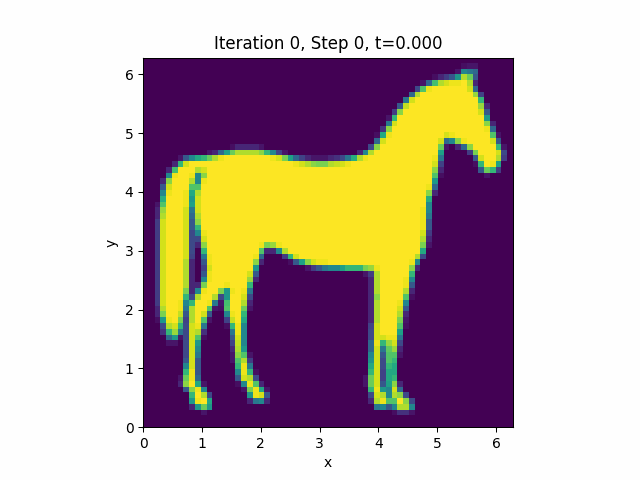

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

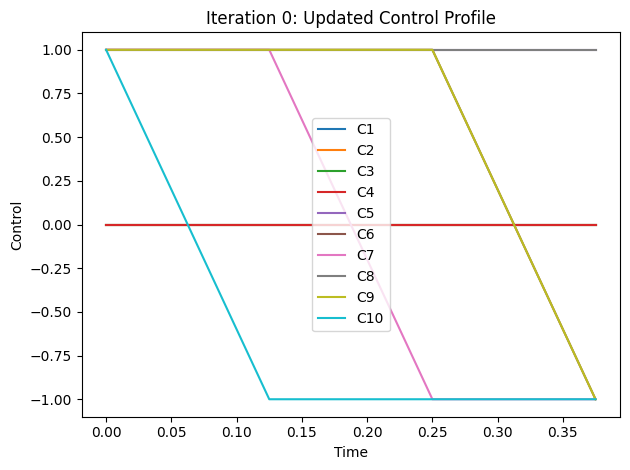

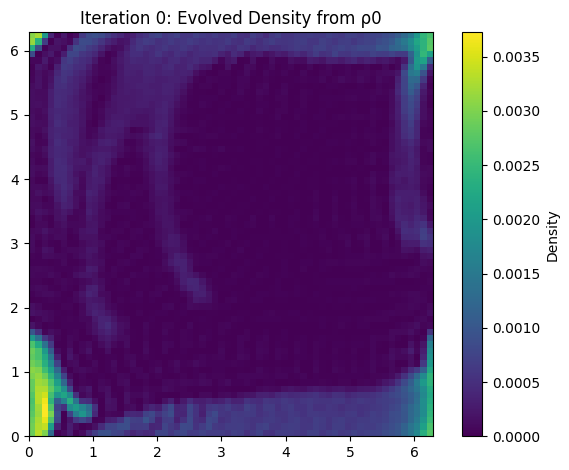

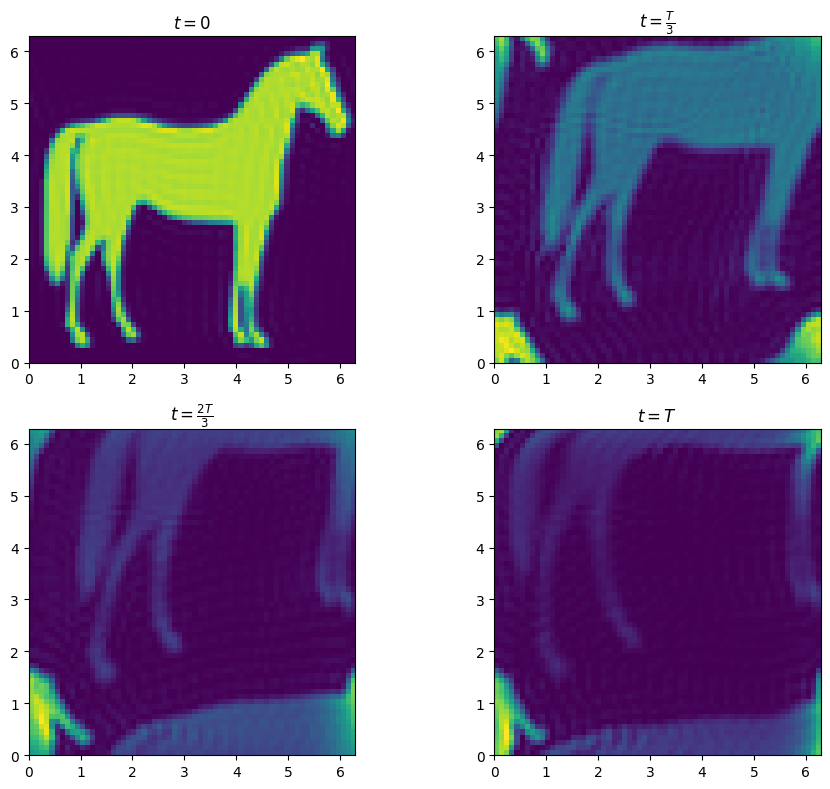


--- Summary ---
1) Each iteration does sign-based updates from the iterative PDE state.
2) We produce and display a GIF and MP4 from the *original* state, with the updated controls.
3) In the final result, we show 4 subplots: t=0, t=T/3, t=2T/3, t=T (no colorbars).
4) We forcibly store final_snapshots[T] = rho to avoid KeyError if we don't land exactly on T.
5) If in Colab, we attempt to download each GIF/MP4 as well.
Done.



In [1]:
#!/usr/bin/env python
# coding: utf-8

"""
Attention_model_on_T2.ipynb

Modified code that:
  1) Performs a sign-based update at each iteration using the PDE solution that
     continues from the previous iteration's final state (iterative PDE).
  2) Once the new control is updated, we generate a GIF and MP4 that *start*
     from the original density ρ0 and evolve to the corresponding ρT for
     that iteration's updated control (no colorbar in snapshots).
  3) In the final results plot, we show densities at t=0, t=T/3, t=2T/3, and t=T
     (again with no colorbars).
  4) The pseudo-spectral approach is retained:
     - Multiplications in real space,
     - Derivatives in Fourier space (via FFT).
  5) We add optional downloads in Colab (GIF/MP4).
  6) We force store final_snapshots[T] to avoid KeyError if we don't land on T exactly.
"""

import sys

# -----------------------------
# Attempt GPU via CuPy
# -----------------------------
try:
    import cupy as cp
    xp = cp
    use_gpu = True
    print("Using CuPy on GPU.")
except ImportError:
    import numpy as xp
    use_gpu = False
    print("Using NumPy on CPU.")

# -----------------------------
# Standard imports
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import resize
import imageio.v2 as imageio
import os

# -----------------------------
# Optional: inline display imports
# -----------------------------
try:
    from IPython.display import HTML, Image, display
    in_ipython = True
except ImportError:
    in_ipython = False

# -----------------------------
# Helper function for safe conversion
# -----------------------------
def to_numpy(arr):
    """Converts array to NumPy array if using CuPy."""
    if use_gpu:
        return cp.asnumpy(arr)
    else:
        return arr

# -----------------------------
# Helper to download in Colab
# -----------------------------
def try_download_in_colab(filename):
    """
    If running in Google Colab, prompt a download of 'filename'
    for local storage if inline playback doesn't work.
    """
    if "google.colab" in sys.modules:
        try:
            from google.colab import files
            files.download(filename)
        except Exception as e:
            print(f"Could not download {filename} in Colab: {e}")

# -----------------------------
# Helper to display MP4 inline
# -----------------------------
def display_mp4_inline(mp4_filename):
    """
    If we're in IPython, display the MP4 with a run bar.
    This might fail if certain codecs are not supported in Colab.
    """
    if in_ipython:
        display(HTML(f"""
        <video controls width="640">
            <source src="{mp4_filename}" type="video/mp4">
        </video>
        """))

# -----------------------------
# Configuration
# -----------------------------
def get_user_config():
    config = {}

    # PDE / domain parameters
    config["res"] = 64            # Grid resolution
    config["T"]   = .5           # Total time horizon
    config["h"]   = config["T"] / 4
    config["epsilon"] = 0.1 * config["h"]
    config["N_iter"] = 1

    # Query/Key matrices (fixed) for attention (here, Q=K=I)
    config["Q_mat"] = xp.array([[1.0,  0.0],
                                [0.0,  1.0]])
    config["K_mat"] = xp.array([[1.0,  0.0],
                                [0.0,  1.0]])

    # Control dimension: 10 channels (first 4 for local drift are unused)
    config["num_channels"] = 10

    # Initial control array
    n_intervals = int(config["T"] / config["h"])
    config["initial_control"] = xp.zeros((config["num_channels"], n_intervals))

    # Active channels (not strictly used here)
    config["active"] = xp.array([0,0,0,0,1,1,1,1,0,0], dtype=xp.float32)

    # Spectral sub-steps and aliasing filter
    config["num_steps_per_interval"] = 30
    config["use_two_thirds_filter"]  = True

    # Sign-based update factor (not used directly in vectorized code)
    config["sign_factor"] = 300.0

    # Density clipping
    config["rho_clip"] = 1e-15

    # (Unused) local drift parameters are removed.
    config["use_sigmoid_local"] = True

    # Smoothness penalty weight
    config["lam_cost"] = 0.0

    # Reference point for cost (torus wrapping)
    config["xstar"] = 0.0000
    config["ystar"] = 0.1000

    # Concentration parameter for periodic attention kernel
    config["kappa"] = 4.9999

    return config

# -----------------------------
# PDE Implementation
# -----------------------------
def main_simulation(config):
    # Unpack configuration parameters
    res   = config["res"]
    T     = config["T"]
    h     = config["h"]
    eps   = config["epsilon"]
    N_iter= config["N_iter"]
    Q_mat = config["Q_mat"]
    K_mat = config["K_mat"]
    kappa = config["kappa"]

    num_channels = config["num_channels"]
    bar_u        = config["initial_control"].copy()
    num_steps_per_interval = config["num_steps_per_interval"]
    use_two_thirds_filter  = config["use_two_thirds_filter"]
    rho_clip               = config["rho_clip"]

    xstar = config["xstar"]
    ystar = config["ystar"]

    # ---------- Grid Setup ----------
    x = xp.linspace(0, 2*xp.pi, res, endpoint=False)
    y = xp.linspace(0, 2*xp.pi, res, endpoint=False)
    dx = 2*xp.pi / res
    X, Y = xp.meshgrid(x, y, indexing='ij')
    area_el = float(dx * dx)

    # Frequencies for spectral derivatives
    k = xp.fft.fftfreq(res) * res
    kx, ky = xp.meshgrid(k, k, indexing='ij')

    # ========== Initial Density ==========
    # Example: Use skimag for the initial distribution
    image = data.horse().astype(float)
    image_inverted = 1 - image
    image_resized = resize(image_inverted, (res, res), anti_aliasing=True)
    image_resized = np.flipud(image_resized)
    rho_initial = xp.array(image_resized)
    rho_initial /= xp.sum(rho_initial)
    original_rho = rho_initial.copy()

    # Flattened coords for attention computations
    coords = xp.stack([X.flatten(), Y.flatten()], axis=1)
    N = coords.shape[0]

    # ========== 2/3 Aliasing Filter ==========
    def two_thirds_filter(f_hat):
        Nx, Ny = f_hat.shape
        cutoff_x = Nx // 3
        cutoff_y = Ny // 3
        f_hat[cutoff_x:-cutoff_x, :] = 0
        f_hat[:, cutoff_y:-cutoff_y] = 0
        return f_hat

    # ========== Local Drift (Removed) ==========
    def compute_local_drift(u):
        return xp.zeros_like(X), xp.zeros_like(X)

    # ========== Periodic Attention Drift ==========
    def compute_periodic_attention_drift(rho, u):
        # Extract V (channels 4:8) and b (channels 8:10)
        V = xp.array([[u[4], u[5]],
                      [u[6], u[7]]])
        b = xp.array([u[8], u[9]])

        rho_flat = rho.flatten()
        p_proj = coords
        q_proj = coords

        diff_mat = p_proj[:, None, :] - q_proj[None, :, :]
        diff_mat = (diff_mat + xp.pi) % (2*xp.pi) - xp.pi
        cos_sum = xp.cos(diff_mat[..., 0]) + xp.cos(diff_mat[..., 1])
        stable_scores = kappa * cos_sum
        row_max = xp.max(stable_scores, axis=1, keepdims=True)
        stable_scores -= row_max
        exp_scores = xp.exp(stable_scores)

        weights = exp_scores * rho_flat[None, :]
        denom = xp.sum(weights, axis=1) + 1e-15
        num = weights @ coords
        attn_vec = num / denom[:, None]
        attn_out = attn_vec @ V.T + b
        return (attn_out.reshape((res, res, 2))[:, :, 0],
                attn_out.reshape((res, res, 2))[:, :, 1])

    # ========== PDE Derivative (Pseudo-Spectral) ==========
    def compute_rho_derivative(t, rho, u):
        _, _ = compute_local_drift(u)
        non_x, non_y = compute_periodic_attention_drift(rho, u)
        drift_x = non_x
        drift_y = non_y

        flux_x = rho * drift_x
        flux_y = rho * drift_y
        flux_x_hat = xp.fft.fft2(flux_x)
        flux_y_hat = xp.fft.fft2(flux_y)

        if use_two_thirds_filter:
            flux_x_hat = two_thirds_filter(flux_x_hat)
            flux_y_hat = two_thirds_filter(flux_y_hat)

        div_flux = xp.fft.ifft2(1j * kx * flux_x_hat + 1j * ky * flux_y_hat).real
        return -div_flux

    # ========== Torus-Wrapped Difference ==========
    def torus_diff(A, a_star):
        return (A - a_star + xp.pi) % (2*xp.pi) - xp.pi

    # ========== Cost Functional ==========
    def compute_cost(rho):
        dx_wrap = torus_diff(X, xstar)
        dy_wrap = torus_diff(Y, ystar)
        return float(xp.sum((dx_wrap**2 + dy_wrap**2) * rho) * area_el)

    # ========== PDE (no frames) for iterative updates ==========
    def simulate_duration(rho_init, control_intervals):
        """
        PDE from a given initial state 'rho_init' to final time T
        with 'control_intervals' sub-interval. No frames saved.
        """
        rho = rho_init.copy()
        dt = h / num_steps_per_interval
        n_int_local = control_intervals.shape[1]
        t_ = 0.0
        for int_idx in range(n_int_local):
            u = control_intervals[:, int_idx]
            for _ in range(num_steps_per_interval):
                k1 = compute_rho_derivative(t_, rho, u)
                k2 = compute_rho_derivative(t_ + 0.5*dt, rho + 0.5*dt*k1, u)
                k3 = compute_rho_derivative(t_ + 0.5*dt, rho + 0.5*dt*k2, u)
                k4 = compute_rho_derivative(t_ + dt, rho + dt*k3, u)
                rho += dt * (k1 + 2*k2 + 2*k3 + k4) / 6
                t_ += dt
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)
        return rho

    # ========== PDE with frames (for GIF/MP4) ==========
    def simulate_duration_with_frames(rho_init, control_intervals,
                                      iteration_index,
                                      tag=""):
        folder_name = f"frames_iter_{iteration_index}{tag}"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        rho = rho_init.copy()
        dt = h / num_steps_per_interval
        n_intervals_local = control_intervals.shape[1]
        step_counter = 0
        t_local = 0.0

        def save_density_frame(rho_val, step_id, time_val):
            plt.figure()
            plt.title(f"Iteration {iteration_index}, Step {step_id}, t={time_val:.3f}")
            plt.imshow(to_numpy(rho_val), origin='lower',
                       extent=[0, 2*np.pi, 0, 2*np.pi],
                       cmap='viridis')
            # No colorbar on frames
            plt.xlabel("x")
            plt.ylabel("y")
            fname = os.path.join(folder_name, f"density_{step_id:04d}.png")
            plt.savefig(fname, dpi=100)
            plt.close()

        # Save initial frame
        save_density_frame(rho, step_counter, t_local)

        for int_idx in range(n_intervals_local):
            u = control_intervals[:, int_idx]
            for _ in range(num_steps_per_interval):
                k1 = compute_rho_derivative(t_local, rho, u)
                k2 = compute_rho_derivative(t_local + 0.5*dt, rho + 0.5*dt*k1, u)
                k3 = compute_rho_derivative(t_local + 0.5*dt, rho + 0.5*dt*k2, u)
                k4 = compute_rho_derivative(t_local + dt, rho + dt*k3, u)
                rho += dt * (k1 + 2*k2 + 2*k3 + k4) / 6
                t_local += dt
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)
                step_counter += 1
                save_density_frame(rho, step_counter, t_local)

        return rho, folder_name

    # ========== Build Animations (GIF & MP4) ==========
    def build_gif_from_frames(frames_folder, output_gif):
        png_files = sorted([f for f in os.listdir(frames_folder) if f.endswith(".png")])
        with imageio.get_writer(output_gif, mode='I', duration=0.3) as writer:
            for filename in png_files:
                image = imageio.imread(os.path.join(frames_folder, filename))
                writer.append_data(image)

    def build_mp4_from_frames(frames_folder, output_mp4, fps=4):
        png_files = sorted([f for f in os.listdir(frames_folder) if f.endswith(".png")])
        # Use the FFmpeg plugin for MP4
        with imageio.get_writer(output_mp4, fps=fps, format="FFMPEG") as writer:
            for filename in png_files:
                image = imageio.imread(os.path.join(frames_folder, filename))
                writer.append_data(image)

    # We'll keep an iterative PDE state
    rho_current_main = original_rho.copy()
    cost_history = []
    density_evolution = []
    control_history = []

    n_intervals = int(T / h)
    if bar_u.shape != (num_channels, n_intervals):
        raise ValueError(f"Expected bar_u shape ({num_channels}, {n_intervals}), got {bar_u.shape}")

    # -------------------------------------
    # Iterations: sign-based updates
    # -------------------------------------
    for k_iter in range(N_iter):
        # (A) Sign-based update from previous iteration's PDE state
        idx = 0
        rho_iter = rho_current_main.copy()
        u_new = xp.zeros_like(bar_u)

        while idx < n_intervals:
            sub_controls = bar_u[:, idx:]
            y_bar = simulate_duration(rho_iter, sub_controls)
            base_cost = compute_cost(y_bar)

            # sign-based update for each channel
            u_t = xp.zeros(num_channels)
            for i in range(num_channels):
                perturb = xp.zeros((num_channels, 1))
                perturb[i, 0] = 1.0
                y_pert = simulate_duration(rho_iter, perturb)
                z_bar = simulate_duration(y_pert, sub_controls)
                cost_pert = compute_cost(z_bar)
                u_t[i] = xp.sign(base_cost - cost_pert)

            u_new[:, idx] = u_t
            # PDE for one interval h with sign-based control
            one_control = u_t.reshape(num_channels, 1)
            rho_iter = simulate_duration(rho_iter, one_control)
            idx += 1

        bar_u = u_new.copy()
        control_history.append(bar_u.copy())

        # PDE from old PDE state with new bar_u => new PDE state
        rho_current_main = simulate_duration(rho_current_main, bar_u)

        # (B) Produce PDE from original rho0 with the new bar_u => frames
        rho_final_for_gif, folder_name = simulate_duration_with_frames(
            original_rho.copy(), bar_u,
            iteration_index=k_iter
        )
        cost_this_iter = compute_cost(rho_final_for_gif)
        cost_history.append(cost_this_iter)
        density_evolution.append(rho_final_for_gif)
        print(f"Iteration {k_iter}, Cost from ρ0 to ρT: {cost_this_iter:.4e}")

        # Build GIF
        gif_filename = f"density_evolution_iter_{k_iter}.gif"
        build_gif_from_frames(folder_name, gif_filename)

        # Inline display + download if in Colab
        if in_ipython:
            display(Image(filename=gif_filename))
        try_download_in_colab(gif_filename)

        # Build MP4 (with FFmpeg plugin)
        mp4_filename = f"density_evolution_iter_{k_iter}.mp4"
        build_mp4_from_frames(folder_name, mp4_filename, fps=4)

        # Try to display run-bar video inline
        display_mp4_inline(mp4_filename)
        try_download_in_colab(mp4_filename)

        # (C) Plot updated control profile
        t_vals = np.arange(n_intervals) * h
        plt.figure()
        for ch in range(num_channels):
            plt.plot(t_vals, to_numpy(bar_u[ch, :]), label=f'C{ch+1}')
        plt.xlabel('Time')
        plt.ylabel('Control')
        plt.title(f'Iteration {k_iter}: Updated Control Profile')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"control_profile_iter{k_iter}.png", dpi=150)
        plt.show()
        plt.close()

        # (D) Plot final density from ρ0
        plt.figure()
        plt.imshow(to_numpy(rho_final_for_gif),
                   extent=[0, 2*np.pi, 0, 2*np.pi],
                   origin='lower', cmap='viridis')
        plt.title(f'Iteration {k_iter}: Evolved Density from ρ0')
        plt.colorbar(label="Density")
        plt.tight_layout()
        plt.savefig(f"evolved_density_iter_{k_iter}.png", dpi=150)
        plt.show()
        plt.close()

    # ---------------------------------------------
    # After N_iter: final PDE state from iteration chain is in 'rho_current_main'.
    #
    # We'll do a separate PDE from 0 to T with final bar_u, logging times
    # t=0, t=T/3, t=2T/3, t=T. We ensure we store T exactly to avoid KeyError.
    # ---------------------------------------------
    def simulate_and_sample(rho_init, control_intervals, T, sample_times):
        """
        PDE from t=0 to t=T in sub-interval steps,
        returns a dict of density snapshots at times in sample_times.

        We'll force final_snapshots[T] = rho at the end to avoid KeyError
        if we don't land on T exactly.
        """
        snapshots = {}
        rho = rho_init.copy()

        dt = h / num_steps_per_interval
        n_int_local = control_intervals.shape[1]
        t_ = 0.0

        times_to_sample = sorted(sample_times)
        sample_idx = 0
        # Record the initial distribution at t=0
        snapshots[times_to_sample[sample_idx]] = rho.copy()

        for int_idx in range(n_int_local):
            u = control_intervals[:, int_idx]
            for _ in range(num_steps_per_interval):
                # One sub-step
                k1 = compute_rho_derivative(t_, rho, u)
                k2 = compute_rho_derivative(t_ + 0.5*dt, rho + 0.5*dt*k1, u)
                k3 = compute_rho_derivative(t_ + 0.5*dt, rho + 0.5*dt*k2, u)
                k4 = compute_rho_derivative(t_ + dt, rho + dt*k3, u)
                rho += dt * (k1 + 2*k2 + 2*k3 + k4) / 6
                t_ += dt
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)

                # Check if we've crossed the next sample time
                while sample_idx < len(times_to_sample):
                    next_sample = times_to_sample[sample_idx]
                    # small tolerance if we want to
                    tol = 1e-12
                    if t_ >= next_sample - tol:
                        snapshots[next_sample] = rho.copy()
                        sample_idx += 1
                        if sample_idx >= len(times_to_sample):
                            break
                    else:
                        break
                if sample_idx >= len(times_to_sample):
                    break
            if sample_idx >= len(times_to_sample):
                break

        # Force store the final PDE state in case we haven't landed exactly on T
        snapshots[T] = rho.copy()

        return snapshots

    # We want times: 0, T/3, 2T/3, T
    sample_times = [0.0, T/3, 2.0*T/3, T]
    final_snapshots = simulate_and_sample(original_rho.copy(), bar_u, T, sample_times)

    # Access with no KeyError:
    rho_0   = final_snapshots[0.0]
    rho_t3  = final_snapshots[T/3]
    rho_2t3 = final_snapshots[2*T/3]
    rho_T   = final_snapshots[T]

    # -----------------------------------------------------
    # Plot 4 subplots: t=0, T/3, 2T/3, T (no colorbars)
    # -----------------------------------------------------
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 2, 1)
    plt.title("$t=0$")
    plt.imshow(to_numpy(rho_0), extent=[0,2*xp.pi,0,2*xp.pi],
               origin='lower', cmap='viridis')

    plt.subplot(2, 2, 2)
    plt.title("$t=\\frac{T}{3}$")
    plt.imshow(to_numpy(rho_t3), extent=[0,2*xp.pi,0,2*xp.pi],
               origin='lower', cmap='viridis')

    plt.subplot(2, 2, 3)
    plt.title("$t=\\frac{2T}{3}$")
    plt.imshow(to_numpy(rho_2t3), extent=[0,2*xp.pi,0,2*xp.pi],
               origin='lower', cmap='viridis')

    plt.subplot(2, 2, 4)
    plt.title("$t=T$")
    plt.imshow(to_numpy(rho_T), extent=[0,2*xp.pi,0,2*xp.pi],
               origin='lower', cmap='viridis')

    plt.tight_layout()
    plt.savefig("final_results_4subplots.png", dpi=150)
    plt.show()
    plt.close()

    print("\n--- Summary ---")
    print("1) Each iteration does sign-based updates from the iterative PDE state.")
    print("2) We produce and display a GIF and MP4 from the *original* state, with the updated controls.")
    print("3) In the final result, we show 4 subplots: t=0, t=T/3, t=2T/3, t=T (no colorbars).")
    print("4) We forcibly store final_snapshots[T] = rho to avoid KeyError if we don't land exactly on T.")
    print("5) If in Colab, we attempt to download each GIF/MP4 as well.")
    print("Done.\n")

# -----------------------------
# Entry Point
# -----------------------------
if __name__ == "__main__":
    config = get_user_config()
    main_simulation(config)
